__Purpose:__ Analyze basic personalization scheme of simply doing Smoothbatch between the global and local models.  E.g. model interpolation to get a personalized model.
> Observed results: the personalized model literally just inhabits the space between the local and global models, which makes sense since it's just a weighting between the two.  Does this imply that the cost function is simpler than we thought (e.g. there aren't as many local mins and it's sort of just a 1D scale like we were seeing before)?
- Can vary smoothbatch (percent new vs old)

In [1]:
import pandas as pd
import os
import numpy as np
import random
from matplotlib import pyplot as plt
from scipy.optimize import minimize
import copy

from experiment_params import *
from cost_funcs import *
from fl_sim_classes import *
import time
import pickle
from sklearn.decomposition import PCA

In [2]:
path = r'C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\Data'
cond0_filename = r'\cond0_dict_list.p'
all_decs_init_filename = r'\all_decs_init.p'
nofl_decs_filename = r'\nofl_decs.p'
id2color = {0:'lightcoral', 1:'maroon', 2:'chocolate', 3:'darkorange', 4:'gold', 5:'olive', 6:'olivedrab', 
            7:'lawngreen', 8:'aquamarine', 9:'deepskyblue', 10:'steelblue', 11:'violet', 12:'darkorchid', 13:'deeppink'}
implemented_client_training_methods = ['EtaGradStep', 'EtaScipyMinStep', 'FullScipyMinStep']
implement_these_methods_next = ['APFL', 'AFL', 'PersA_FL_MAML', 'PersA_FL_ME', 'PFA']
num_participants = 14

# For exclusion when plotting later on
bad_nodes = [1,3,13]

with open(path+cond0_filename, 'rb') as fp:
    cond0_training_and_labels_lst = pickle.load(fp)
    
with open(path+all_decs_init_filename, 'rb') as fp:
    init_decoders = pickle.load(fp)
cond0_init_decs = [dec[0, :, :] for dec in init_decoders]

D_0 = np.random.rand(2,64)
D_0_7 = np.random.rand(2,7)

# Federated Learning: FedAvgSB
## 1 Scipy Step, 500 Iterations
> Note that the thicker, lighter lines are the global model accuracies, whereas the thin lines are the local accuracies.

Client 1: New update after lrt passed: (new update, current global round, current local round): (11, 0, 25)

Client 1: New update after lrt passed: (new update, current global round, current local round): (12, 0, 50)

Client 1: New update after lrt passed: (new update, current global round, current local round): (13, 0, 75)

Client 1: New update after lrt passed: (new update, current global round, current local round): (14, 0, 100)

Client 1: New update after lrt passed: (new update, current global round, current local round): (15, 0, 125)

Client 1: New update after lrt passed: (new update, current global round, current local round): (16, 0, 150)



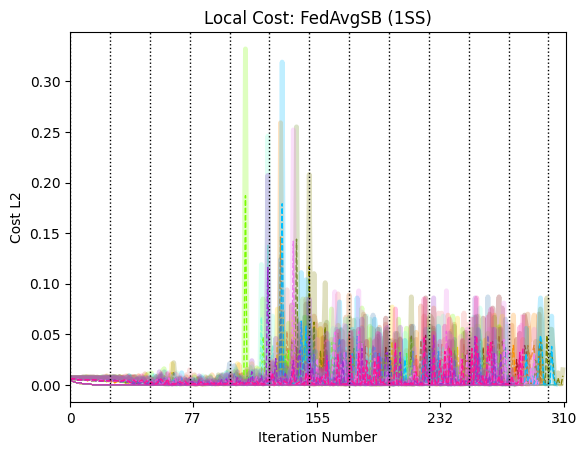

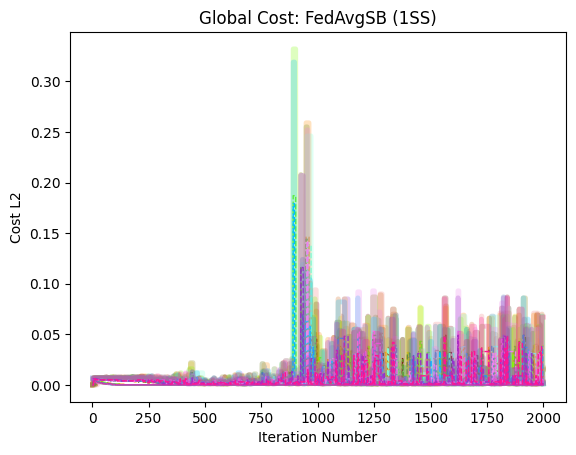

In [3]:
user_c0_1ScipyStep = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming', delay_scaling=0, verbose=True) for i in range(14)]
global_model_1scipystep = Server(1, D_0_7, 'FedAvgSB', user_c0_1ScipyStep)

big_loop_iters = 500
for i in range(big_loop_iters):
    global_model_1scipystep.execute_FL_loop()
    
condensed_external_plotting(user_c0_1ScipyStep, 'local', pers_error=True, custom_title='Local Cost: FedAvgSB (1SS)')
condensed_external_plotting(global_model_1scipystep, 'global', pers_error=True, show_update_change=False, custom_title='Global Cost: FedAvgSB (1SS)')

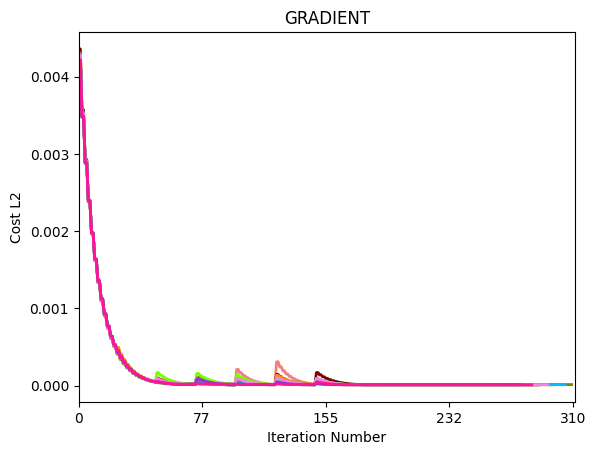

In [4]:
condensed_external_plotting(user_c0_1ScipyStep, 'local', plot_gradient=True, local_error=False, global_error=False, show_update_change=False, custom_title='GRADIENT')

This is the personalized gradient, but I just calculated the gradient using the existing F, H, V and then just replaced self.w with self.mixed_w for D.  V is calculated using self.w so this gradient is kind of fake

In [5]:
#condensed_external_plotting(user_c0_1ScipyStep, 'local', plot_pers_gradient=True, local_error=False, global_error=False, show_update_change=False, custom_title='PERS GRADIENT')

Client 1: New update after lrt passed: (new update, current global round, current local round): (11, 0, 25)

Client 1: New update after lrt passed: (new update, current global round, current local round): (12, 0, 50)

Client 1: New update after lrt passed: (new update, current global round, current local round): (13, 0, 75)

Client 1: New update after lrt passed: (new update, current global round, current local round): (14, 0, 100)

Client 1: New update after lrt passed: (new update, current global round, current local round): (15, 0, 125)

Client 1: New update after lrt passed: (new update, current global round, current local round): (16, 0, 150)



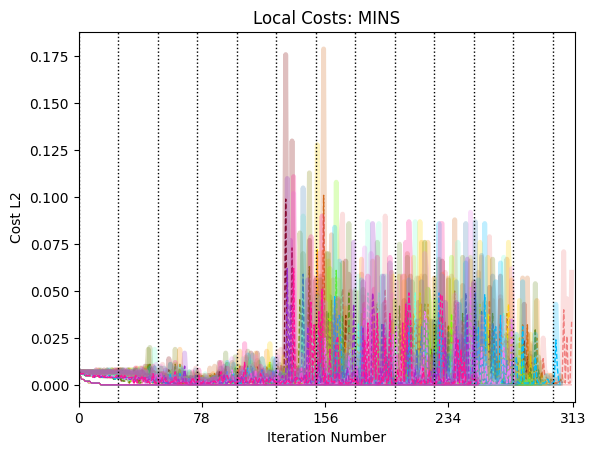

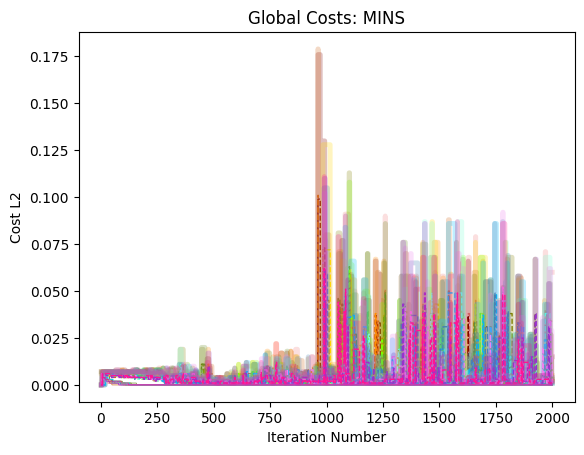

In [6]:
user_c0_1ScipyStep = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming', mix_in_each_steps=True, delay_scaling=0, verbose=True) for i in range(14)]
global_model_1scipystep = Server(1, D_0_7, 'FedAvgSB', user_c0_1ScipyStep)

for i in range(big_loop_iters):
    global_model_1scipystep.execute_FL_loop()
    
condensed_external_plotting(user_c0_1ScipyStep, 'local', pers_error=True, custom_title='Local Costs: MINS')
condensed_external_plotting(global_model_1scipystep, 'global', pers_error=True, show_update_change=False, custom_title='Global Costs: MINS')

Client 1: New update after lrt passed: (new update, current global round, current local round): (11, 0, 25)

Client 1: New update after lrt passed: (new update, current global round, current local round): (12, 0, 50)

Client 1: New update after lrt passed: (new update, current global round, current local round): (13, 0, 75)

Client 1: New update after lrt passed: (new update, current global round, current local round): (14, 0, 100)

Client 1: New update after lrt passed: (new update, current global round, current local round): (15, 0, 125)

Client 1: New update after lrt passed: (new update, current global round, current local round): (16, 0, 150)



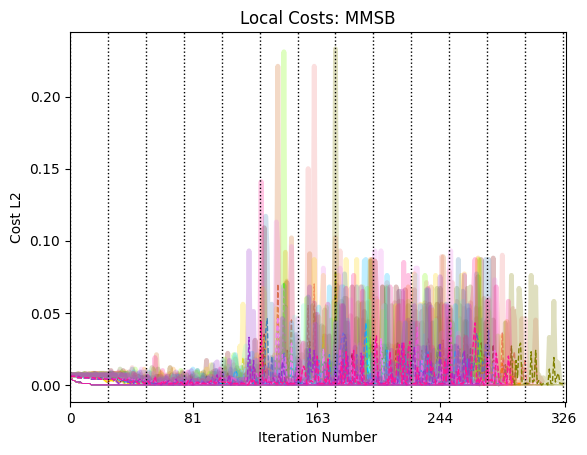

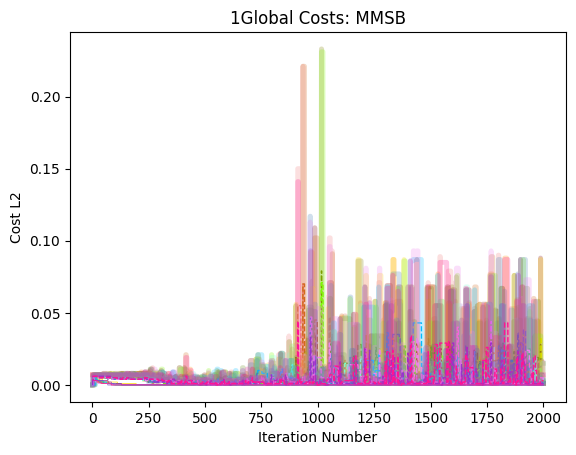

In [7]:
user_c0_1ScipyStep = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming', mix_mixed_SB=True, delay_scaling=0, verbose=True) for i in range(14)]
global_model_1scipystep = Server(1, D_0_7, 'FedAvgSB', user_c0_1ScipyStep)

for i in range(big_loop_iters):
    global_model_1scipystep.execute_FL_loop()
    
condensed_external_plotting(user_c0_1ScipyStep, 'local', pers_error=True, custom_title='Local Costs: MMSB')
condensed_external_plotting(global_model_1scipystep, 'global', pers_error=True, show_update_change=False, custom_title='1Global Costs: MMSB')

Client 1: New update after lrt passed: (new update, current global round, current local round): (11, 0, 25)

Client 1: New update after lrt passed: (new update, current global round, current local round): (12, 0, 50)

Client 1: New update after lrt passed: (new update, current global round, current local round): (13, 0, 75)

Client 1: New update after lrt passed: (new update, current global round, current local round): (14, 0, 100)

Client 1: New update after lrt passed: (new update, current global round, current local round): (15, 0, 125)

Client 1: New update after lrt passed: (new update, current global round, current local round): (16, 0, 150)



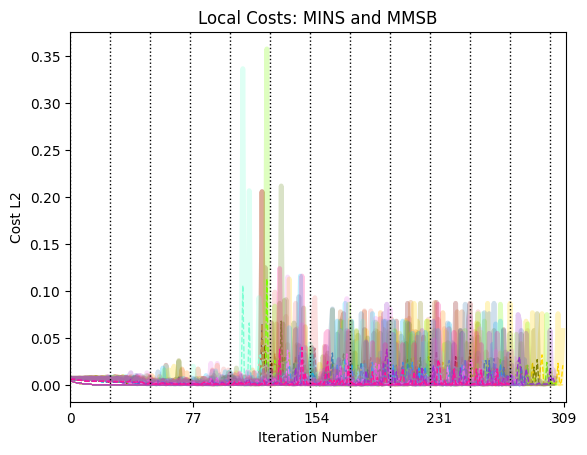

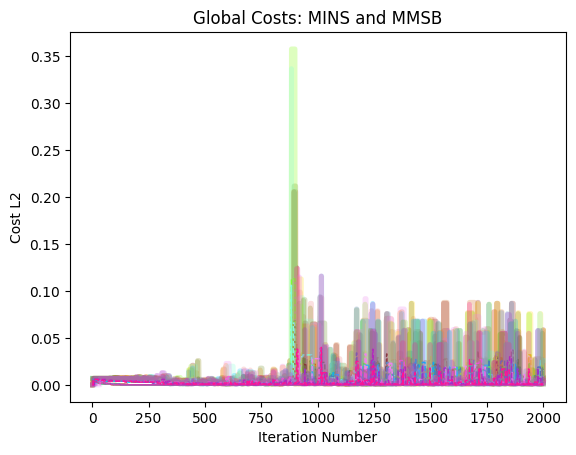

In [8]:
user_c0_1ScipyStep = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming', mix_in_each_steps=True, mix_mixed_SB=True, delay_scaling=0, verbose=True) for i in range(14)]
global_model_1scipystep = Server(1, D_0_7, 'FedAvgSB', user_c0_1ScipyStep)

for i in range(big_loop_iters):
    global_model_1scipystep.execute_FL_loop()
    
condensed_external_plotting(user_c0_1ScipyStep, 'local', pers_error=True, custom_title='Local Costs: MINS and MMSB')
condensed_external_plotting(global_model_1scipystep, 'global', pers_error=True, show_update_change=False, custom_title='Global Costs: MINS and MMSB')

## 10 Steps

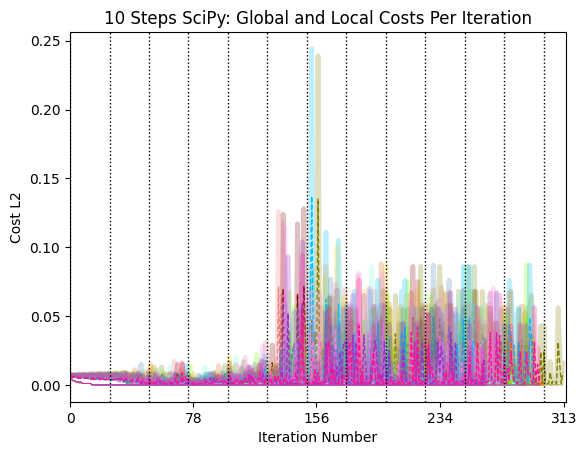

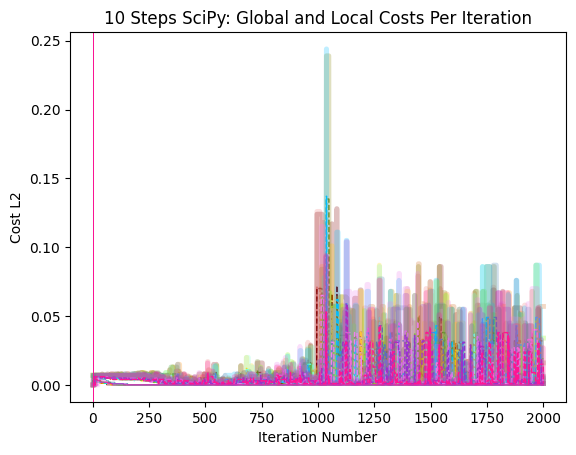

In [9]:
user_c0_10scipy = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming', num_steps=10, delay_scaling=0) for i in range(14)]
global_model_10scipy = Server(2, D_0_7, 'FedAvgSB', user_c0_10scipy)

for i in range(big_loop_iters):
    global_model_10scipy.execute_FL_loop()
    
condensed_external_plotting(user_c0_10scipy, 'local', pers_error=True, custom_title='10 Steps SciPy: Global and Local Costs Per Iteration')
condensed_external_plotting(global_model_10scipy, 'global', pers_error=True, custom_title='10 Steps SciPy: Global and Local Costs Per Iteration')

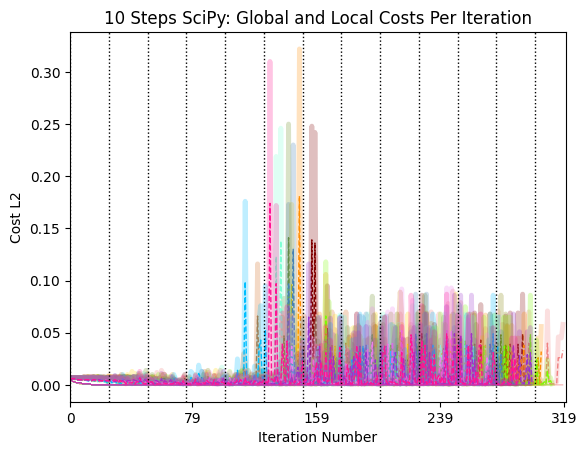

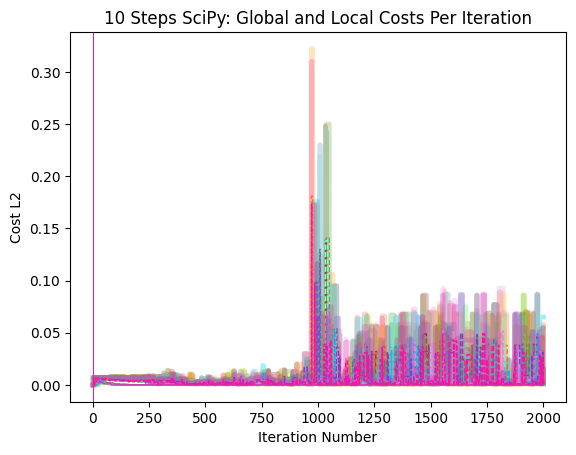

In [10]:
user_c0_10scipy = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming', mix_in_each_steps=True, num_steps=10, delay_scaling=0) for i in range(14)]
global_model_10scipy = Server(2, D_0_7, 'FedAvgSB', user_c0_10scipy)

for i in range(big_loop_iters):
    global_model_10scipy.execute_FL_loop()
    
condensed_external_plotting(user_c0_10scipy, 'local', pers_error=True, custom_title='10 Steps SciPy: Global and Local Costs Per Iteration')
condensed_external_plotting(global_model_10scipy, 'global', pers_error=True, custom_title='10 Steps SciPy: Global and Local Costs Per Iteration')

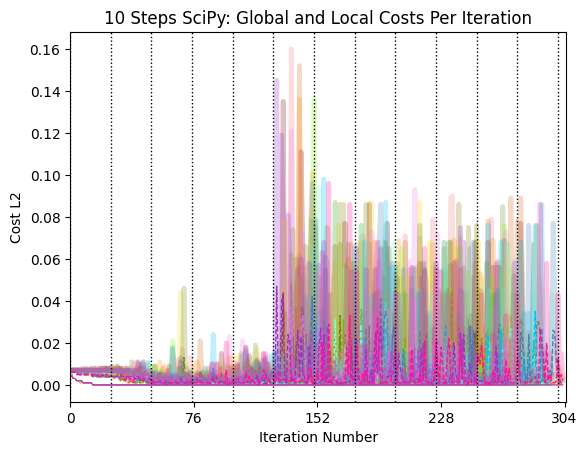

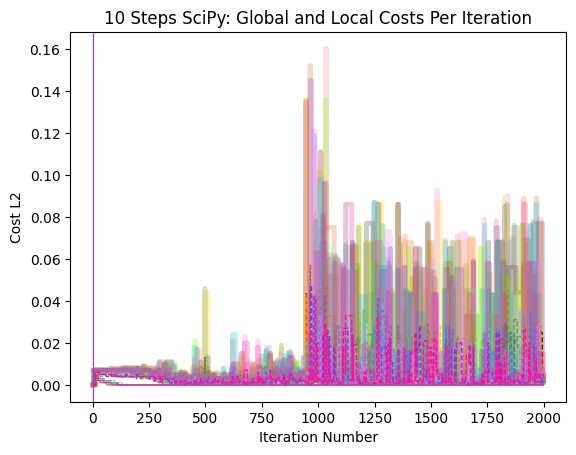

In [11]:
user_c0_10scipy = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming', mix_mixed_SB=True,  num_steps=10, delay_scaling=0) for i in range(14)]
global_model_10scipy = Server(2, D_0_7, 'FedAvgSB', user_c0_10scipy)

for i in range(big_loop_iters):
    global_model_10scipy.execute_FL_loop()
    
condensed_external_plotting(user_c0_10scipy, 'local', pers_error=True, custom_title='10 Steps SciPy: Global and Local Costs Per Iteration')
condensed_external_plotting(global_model_10scipy, 'global', pers_error=True, custom_title='10 Steps SciPy: Global and Local Costs Per Iteration')

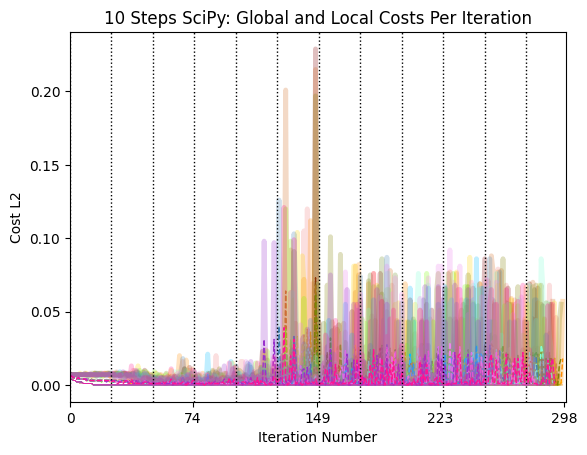

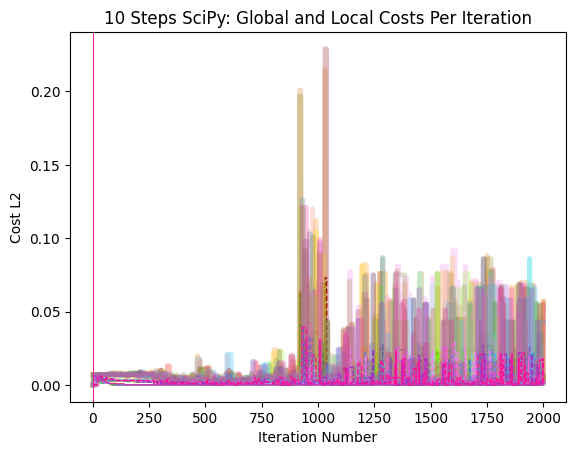

In [12]:
user_c0_10scipy = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming', mix_in_each_steps=True, mix_mixed_SB=True, num_steps=10, delay_scaling=0) for i in range(14)]
global_model_10scipy = Server(2, D_0_7, 'FedAvgSB', user_c0_10scipy)

for i in range(big_loop_iters):
    global_model_10scipy.execute_FL_loop()
    
condensed_external_plotting(user_c0_10scipy, 'local', pers_error=True, custom_title='10 Steps SciPy: Global and Local Costs Per Iteration')
condensed_external_plotting(global_model_10scipy, 'global', pers_error=True, custom_title='10 Steps SciPy: Global and Local Costs Per Iteration')

## Full Scipy.Minimize
> Remember we are starting at update 10 already!!

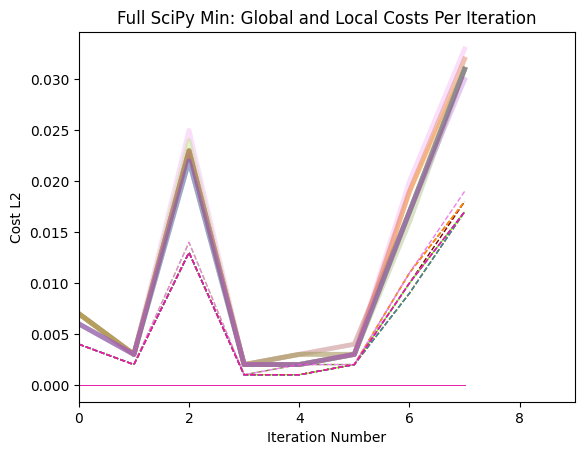

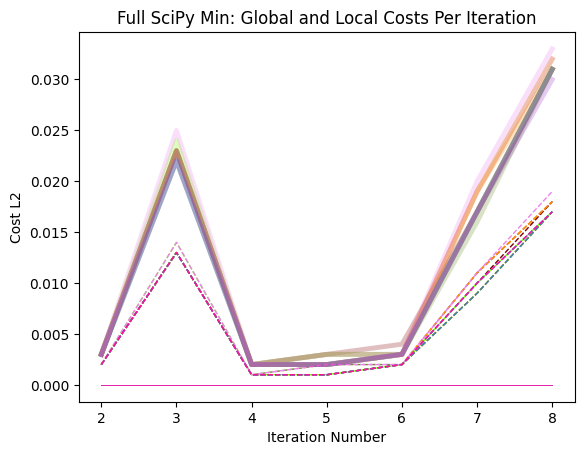

In [13]:
user_c0_fullscipy = [Client(i, D_0_7, 'FullScipyMinStep', cond0_training_and_labels_lst[i], 'advance_each_iter', delay_scaling=0) for i in range(14)]
global_model_fullscipy = Server(4, D_0_7, 'FedAvgSB', user_c0_fullscipy, C=1)

for i in range(8):
    global_model_fullscipy.execute_FL_loop()
    
condensed_external_plotting(user_c0_fullscipy, 'local', pers_error=True, dim_reduc_factor=1, show_update_change=False, custom_title='Full SciPy Min: Global and Local Costs Per Iteration')
condensed_external_plotting(global_model_fullscipy, 'global', pers_error=True, dim_reduc_factor=1, show_update_change=False, custom_title='Full SciPy Min: Global and Local Costs Per Iteration')


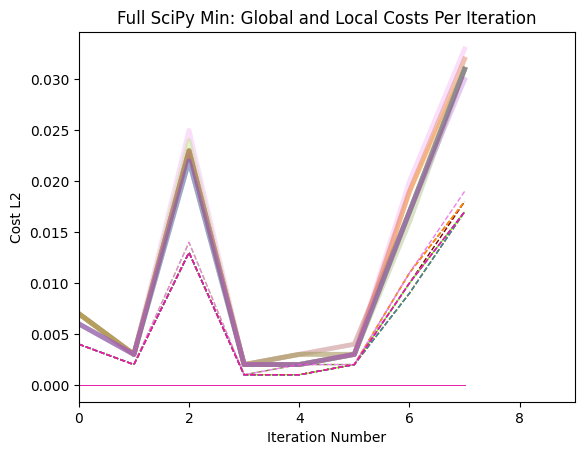

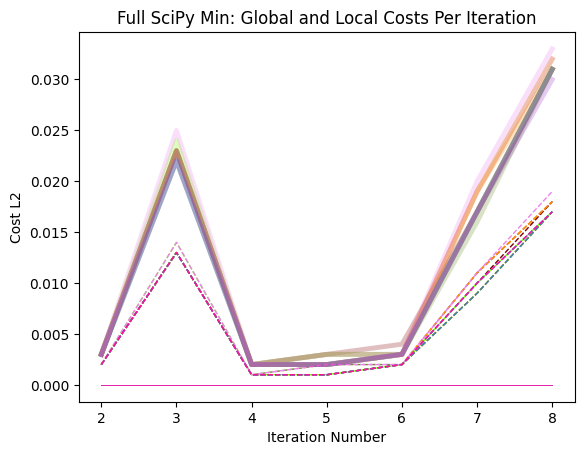

In [14]:
user_c0_fullscipy = [Client(i, D_0_7, 'FullScipyMinStep', cond0_training_and_labels_lst[i], 'advance_each_iter', mix_in_each_steps=True, delay_scaling=0) for i in range(14)]
global_model_fullscipy = Server(4, D_0_7, 'FedAvgSB', user_c0_fullscipy, C=1)

for i in range(8):
    global_model_fullscipy.execute_FL_loop()
    
condensed_external_plotting(user_c0_fullscipy, 'local', pers_error=True, dim_reduc_factor=1, show_update_change=False, custom_title='Full SciPy Min: Global and Local Costs Per Iteration')
condensed_external_plotting(global_model_fullscipy, 'global', pers_error=True, dim_reduc_factor=1, show_update_change=False, custom_title='Full SciPy Min: Global and Local Costs Per Iteration')


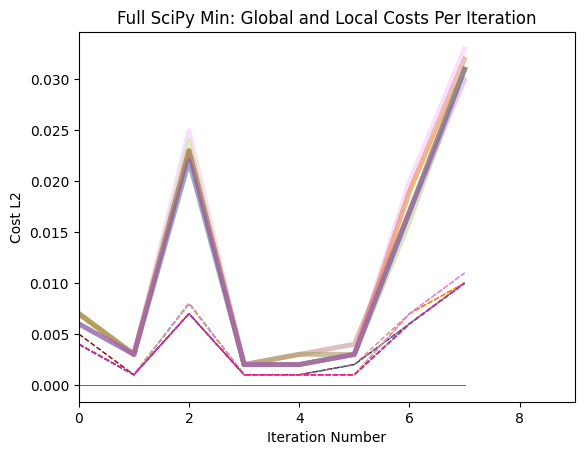

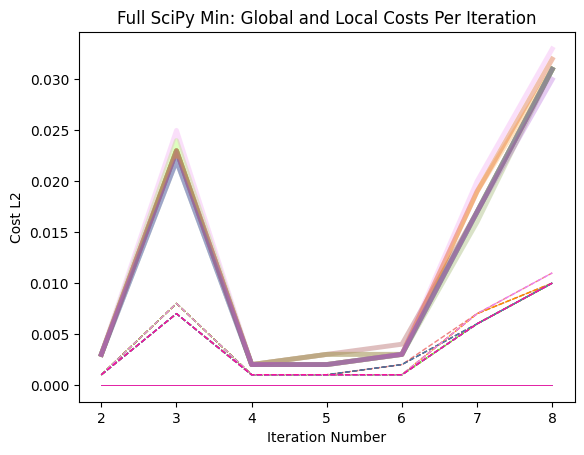

In [15]:
user_c0_fullscipy = [Client(i, D_0_7, 'FullScipyMinStep', cond0_training_and_labels_lst[i], 'advance_each_iter', mix_mixed_SB=True, delay_scaling=0) for i in range(14)]
global_model_fullscipy = Server(4, D_0_7, 'FedAvgSB', user_c0_fullscipy, C=1)

for i in range(8):
    global_model_fullscipy.execute_FL_loop()
    
condensed_external_plotting(user_c0_fullscipy, 'local', pers_error=True, dim_reduc_factor=1, show_update_change=False, custom_title='Full SciPy Min: Global and Local Costs Per Iteration')
condensed_external_plotting(global_model_fullscipy, 'global', pers_error=True, dim_reduc_factor=1, show_update_change=False, custom_title='Full SciPy Min: Global and Local Costs Per Iteration')


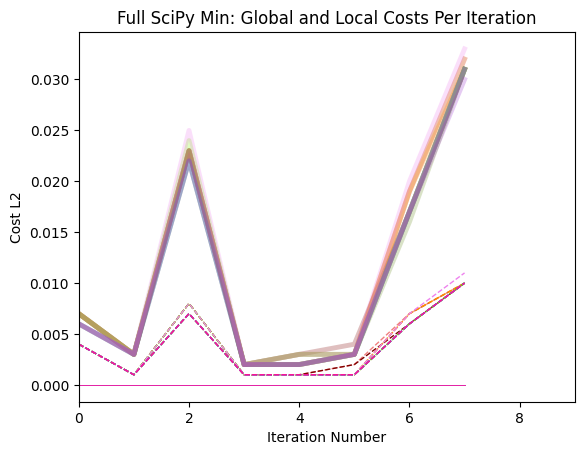

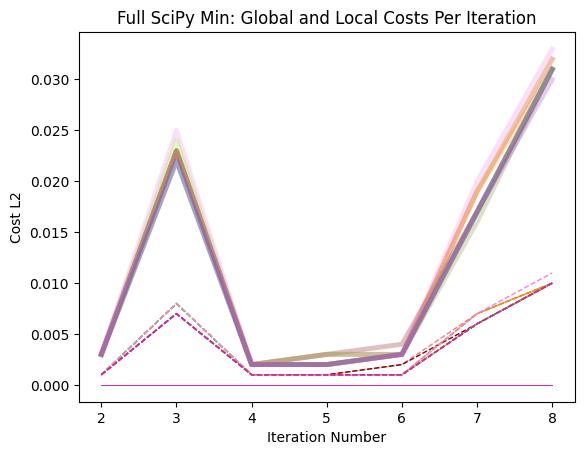

In [16]:
user_c0_fullscipy = [Client(i, D_0_7, 'FullScipyMinStep', cond0_training_and_labels_lst[i], 'advance_each_iter', mix_in_each_steps=True, mix_mixed_SB=True, delay_scaling=0) for i in range(14)]
global_model_fullscipy = Server(4, D_0_7, 'FedAvgSB', user_c0_fullscipy, C=1)

for i in range(8):
    global_model_fullscipy.execute_FL_loop()
    
condensed_external_plotting(user_c0_fullscipy, 'local', pers_error=True, dim_reduc_factor=1, show_update_change=False, custom_title='Full SciPy Min: Global and Local Costs Per Iteration')
condensed_external_plotting(global_model_fullscipy, 'global', pers_error=True, dim_reduc_factor=1, show_update_change=False, custom_title='Full SciPy Min: Global and Local Costs Per Iteration')


# Testing Various SmoothBatches
> 10 Scipy Steps

In [17]:
sb1 = 0.01

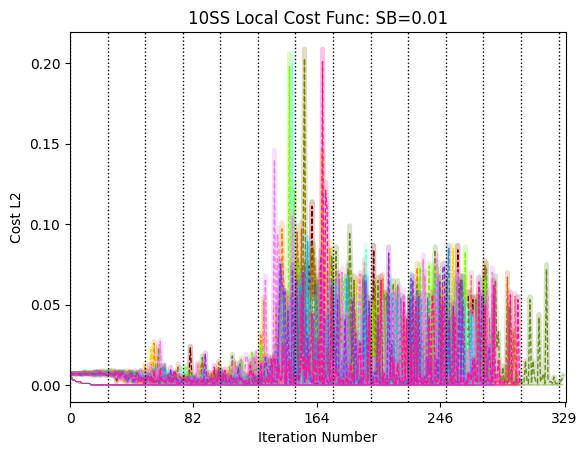

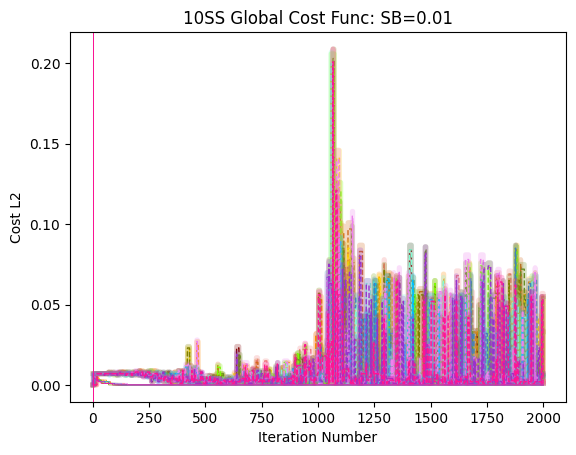

In [18]:
user_c0_10scipy = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming', mix_in_each_steps=True, smoothbatch=sb1, mix_mixed_SB=True, num_steps=10, delay_scaling=0) for i in range(14)]
global_model_10scipy = Server(2, D_0_7, 'FedAvgSB', user_c0_10scipy, smoothbatch=sb1)

for i in range(big_loop_iters):
    global_model_10scipy.execute_FL_loop()
    
condensed_external_plotting(user_c0_10scipy, 'local', pers_error=True, custom_title=f'10SS Local Cost Func: SB={sb1}')
condensed_external_plotting(global_model_10scipy, 'global', pers_error=True, custom_title=f'10SS Global Cost Func: SB={sb1}')

In [19]:
sb1_ = 0.1

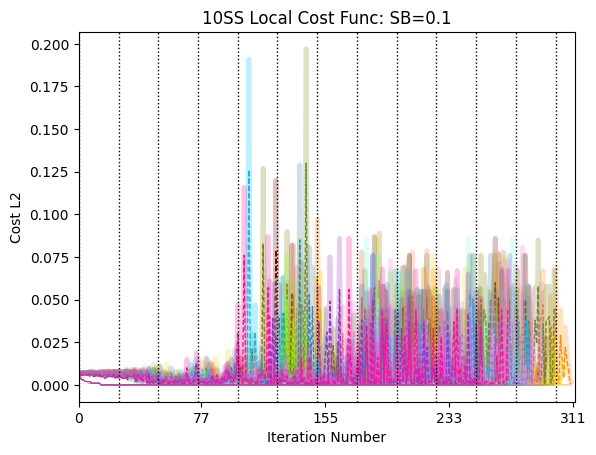

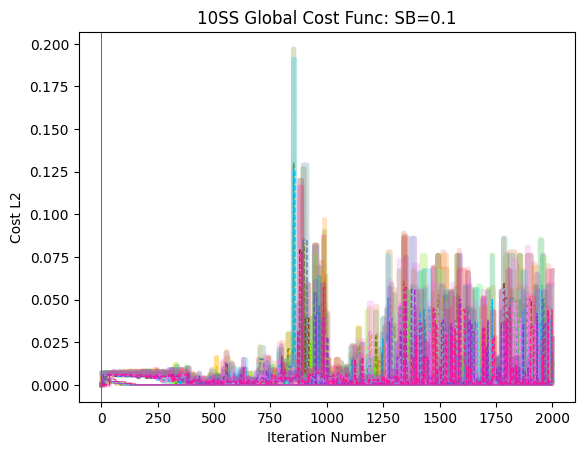

In [20]:
user_c0_10scipy = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming', mix_in_each_steps=True, smoothbatch=sb1_, mix_mixed_SB=True, num_steps=10, delay_scaling=0) for i in range(14)]
global_model_10scipy = Server(2, D_0_7, 'FedAvgSB', user_c0_10scipy, smoothbatch=sb1_)

for i in range(big_loop_iters):
    global_model_10scipy.execute_FL_loop()
    
condensed_external_plotting(user_c0_10scipy, 'local', pers_error=True, custom_title=f'10SS Local Cost Func: SB={sb1_}')
condensed_external_plotting(global_model_10scipy, 'global', pers_error=True, custom_title=f'10SS Global Cost Func: SB={sb1_}')

In [21]:
sb2 = 0.5

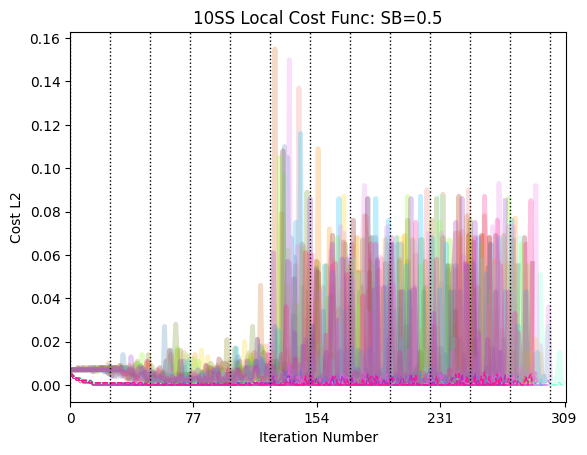

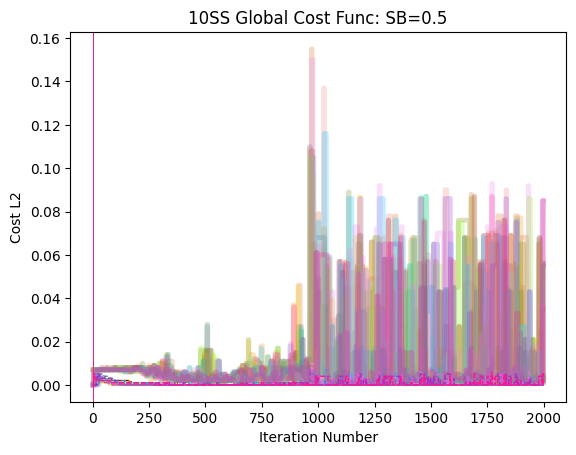

In [22]:
user_c0_10scipy = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming', smoothbatch=sb2, mix_in_each_steps=True, mix_mixed_SB=True, num_steps=10, delay_scaling=0) for i in range(14)]
global_model_10scipy = Server(2, D_0_7, 'FedAvgSB', user_c0_10scipy, smoothbatch=sb2)

for i in range(big_loop_iters):
    global_model_10scipy.execute_FL_loop()
    
condensed_external_plotting(user_c0_10scipy, 'local', pers_error=True, custom_title=f'10SS Local Cost Func: SB={sb2}')
condensed_external_plotting(global_model_10scipy, 'global', pers_error=True, custom_title=f'10SS Global Cost Func: SB={sb2}')

In [23]:
sb3 = 0.75

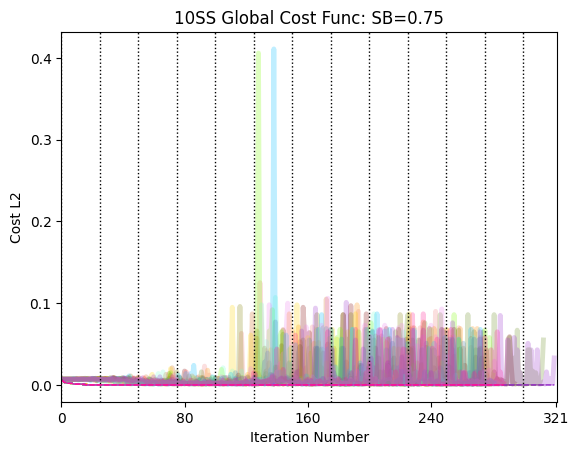

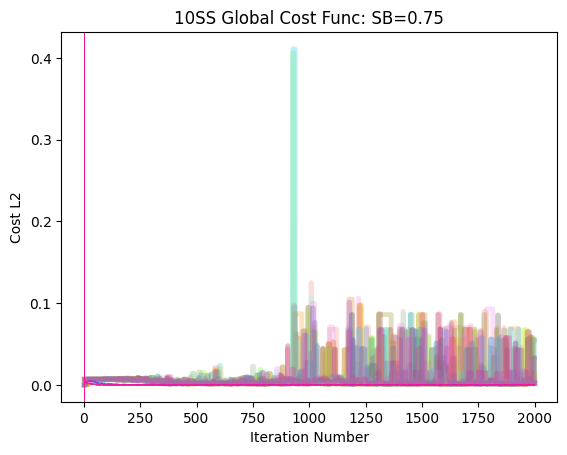

In [24]:
user_c0_10scipy = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming', mix_in_each_steps=True, smoothbatch=sb3, mix_mixed_SB=True, num_steps=10, delay_scaling=0) for i in range(14)]
global_model_10scipy = Server(2, D_0_7, 'FedAvgSB', user_c0_10scipy, smoothbatch=sb3)

for i in range(big_loop_iters):
    global_model_10scipy.execute_FL_loop()
    
condensed_external_plotting(user_c0_10scipy, 'local', pers_error=True, custom_title=f'10SS Global Cost Func: SB={sb3}')
condensed_external_plotting(global_model_10scipy, 'global', pers_error=True, custom_title=f'10SS Global Cost Func: SB={sb3}')

In [25]:
sb4 = 0.9

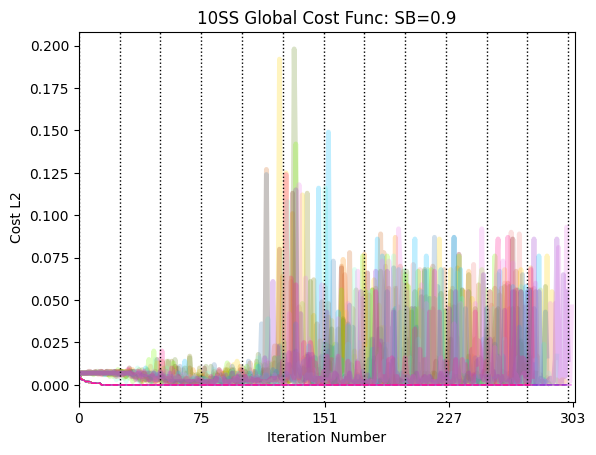

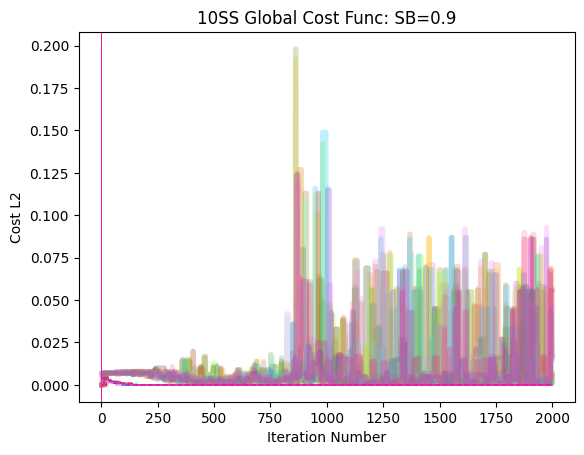

In [26]:
user_c0_10scipy = [Client(i, D_0_7, 'EtaScipyMinStep', cond0_training_and_labels_lst[i], 'streaming', smoothbatch=sb4, mix_in_each_steps=True, mix_mixed_SB=True, num_steps=10, delay_scaling=0) for i in range(14)]
global_model_10scipy = Server(2, D_0_7, 'FedAvgSB', user_c0_10scipy, smoothbatch=sb4)

for i in range(big_loop_iters):
    global_model_10scipy.execute_FL_loop()
    
condensed_external_plotting(user_c0_10scipy, 'local', pers_error=True, custom_title=f'10SS Global Cost Func: SB={sb4}')
condensed_external_plotting(global_model_10scipy, 'global', pers_error=True, custom_title=f'10SS Global Cost Func: SB={sb4}')